In [33]:
import rioxarray
import geopandas
import matplotlib.pyplot as plt
import pickle
import numpy as np
import subprocess

### Inspect and compile input data

We will start with three raster files representing optical, elevation and slope features of the area of interest. 
In this demo, you are free to use a prepared for you beforehand dataset of Hardangerjøkulen, Southern Norway. 
These demonstration data can be accessed at https://bit.ly/3T9wvNC.
If you, however, want to use your own data, make sure that the rasters are defined on the same grid. 

In [5]:
# input paths, adjust as needed
input_folder = "hardangerjokulen/inputs"
optical_path = f"{input_folder}/optical.tiff"
elevation_path = f"{input_folder}/elevation.tiff"
slope_path = f"{input_folder}/slope.tiff"

In [7]:
# read raster files
optical = rioxarray.open_rasterio(optical_path)
elevation = rioxarray.open_rasterio(elevation_path)
slope = rioxarray.open_rasterio(slope_path)

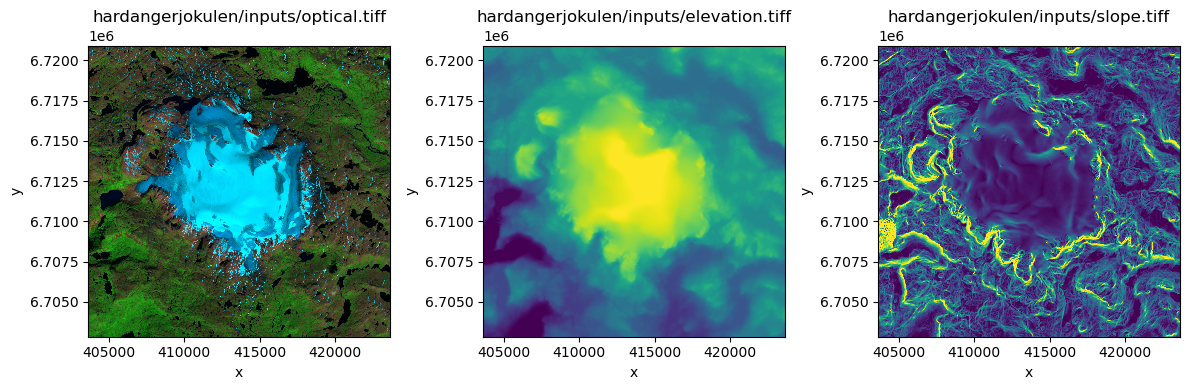

In [11]:
# visualise the inputs
_, axs = plt.subplots(ncols=3, figsize=(12, 4))

optical[[5, 3, 2]].plot.imshow(ax=axs[0], robust=True)
elevation[0].plot.imshow(ax=axs[1], robust=True, add_colorbar=False)
slope[0].plot.imshow(ax=axs[2], robust=True, add_colorbar=False)

axs[0].set_title(optical_path)
axs[1].set_title(elevation_path)
axs[2].set_title(slope_path)

plt.tight_layout()
plt.show()

In [12]:
# compile features into one binary file using an external script
features_path = f"{input_folder}/features.pickle"

command = f"""
    python compile_features.py --optical "{optical_path}" --elevation "{elevation_path}" --slope "{slope_path}" --output "{features_path}"
"""

In [13]:
subprocess.run(command, shell=True)

CompletedProcess(args='\n    python compile_features.py --optical "hardangerjokulen/inputs/optical.tiff" --elevation "hardangerjokulen/inputs/elevation.tiff" --slope "hardangerjokulen/inputs/slope.tiff" --output "hardangerjokulen/inputs/features.pickle"\n', returncode=0)

In [15]:
# the pickle file is just a collection of the feature arrays and metadata to restore geoferencing later
with open(features_path, "rb") as features_src:
    arrs, meta = pickle.load(features_src)

In [16]:
arrs

{'optical': array([[[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],
 
        [[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],
 
        [[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],
 
        ...,
 
        [[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],
 
        [[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0

In [17]:
meta

{'height': 1808,
 'width': 2001,
 'pad_height': 56,
 'pad_width': 151,
 'meta': {'driver': 'GTiff',
  'dtype': None,
  'nodata': None,
  'width': 2001,
  'height': 1808,
  'count': -1,
  'crs': CRS.from_epsg(32632),
  'transform': Affine(10.0, 0.0, 403620.0,
         0.0, -10.0, 6720920.0)}}

### Run model

Once the features are compiled, we can run the model.
Here, we first specify the parameters and, similarly to above, call an external script.

In [22]:
output_folder = "hardangerjokulen/outputs"
model_name = "glavitu_global" # make sure to add the model weights to the weights folder beforehand
features = ["optical", "dem"]
confidence_calibration_model_path = "confidence_calibration_models/confidence_calibration_model_glavitu_global_softmax.pickle"
smoothing = 3 # median smoothing window applied to predictions

command = f"""
    python deploy.py {features_path} -o "{output_folder}" -n {model_name} -f {' '.join(features)} -cm "{confidence_calibration_model_path}" --smoothing {smoothing}
"""

In [28]:
subprocess.call(command, shell=True)

2024-09-02 09:15:52.235694: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-02 09:15:54.079714: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-09-02 09:15:54.115425: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-09-02 09:15:54.116975: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there m

1/1 - 9s - 9s/epoch - 9s/step
1/1 - 0s - 212ms/epoch - 212ms/step
1/1 - 0s - 209ms/epoch - 209ms/step
1/1 - 0s - 208ms/epoch - 208ms/step
1/1 - 0s - 205ms/epoch - 205ms/step
1/1 - 0s - 206ms/epoch - 206ms/step
1/1 - 0s - 207ms/epoch - 207ms/step
1/1 - 0s - 205ms/epoch - 205ms/step
1/1 - 0s - 206ms/epoch - 206ms/step
1/1 - 0s - 207ms/epoch - 207ms/step
1/1 - 0s - 206ms/epoch - 206ms/step
1/1 - 0s - 205ms/epoch - 205ms/step


100%|██████████| 111/111 [00:07<00:00, 14.42it/s]


0

### Inspect outputs

The script yielded two raster files, let's have a look at them.

In [29]:
raster_outlines_path = f"{output_folder}/outlines.tif"
confidence_path = f"{output_folder}/confidence.tif"

In [30]:
raster_outlines = rioxarray.open_rasterio(raster_outlines_path)
confidence = rioxarray.open_rasterio(confidence_path)

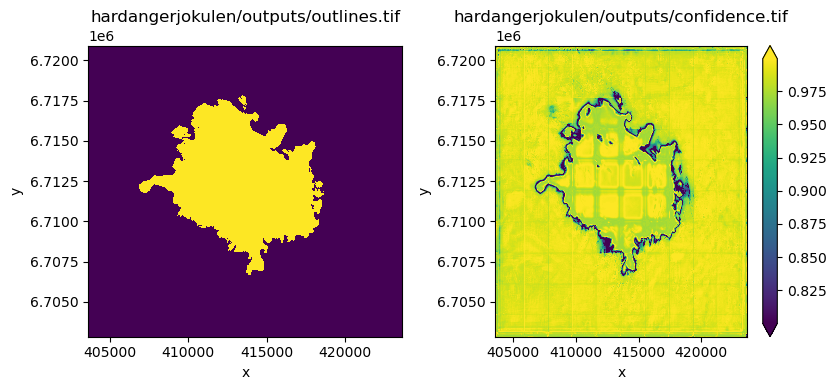

In [32]:
_, axs = plt.subplots(ncols=2, figsize=(8.5, 4))

raster_outlines[0].plot.imshow(ax=axs[0], vmin=0, vmax=1, add_colorbar=False)
confidence[0].plot.imshow(ax=axs[1], robust=True)

axs[0].set_title(raster_outlines_path)
axs[1].set_title(confidence_path)

plt.tight_layout()
plt.show()

### Vectorise outputs and visualise

Optinally, one can prepare the 95%-confidence bands out of the raster and vectorise everything for further analysis.

In [34]:
# confidence bands preparation
raster_confidence_bands_path = f"{output_folder}/confidence_bands.tif"

confidence_bands = (confidence < 0.95).astype(np.uint8)
confidence_bands.rio.to_raster(raster_confidence_bands_path)

In [37]:
# vectorise the final outputs
vector_outlines_path = f"{output_folder}/outlines.geojson"
vector_confidence_bands_path = f"{output_folder}/confidence_bands.geojson"

command = f"""
    python utils/geo/polygonise.py "{raster_outlines_path}" "{vector_outlines_path}";
    python utils/geo/polygonise.py "{raster_confidence_bands_path}" "{vector_confidence_bands_path}";
"""

In [38]:
subprocess.call(command, shell=True)

0

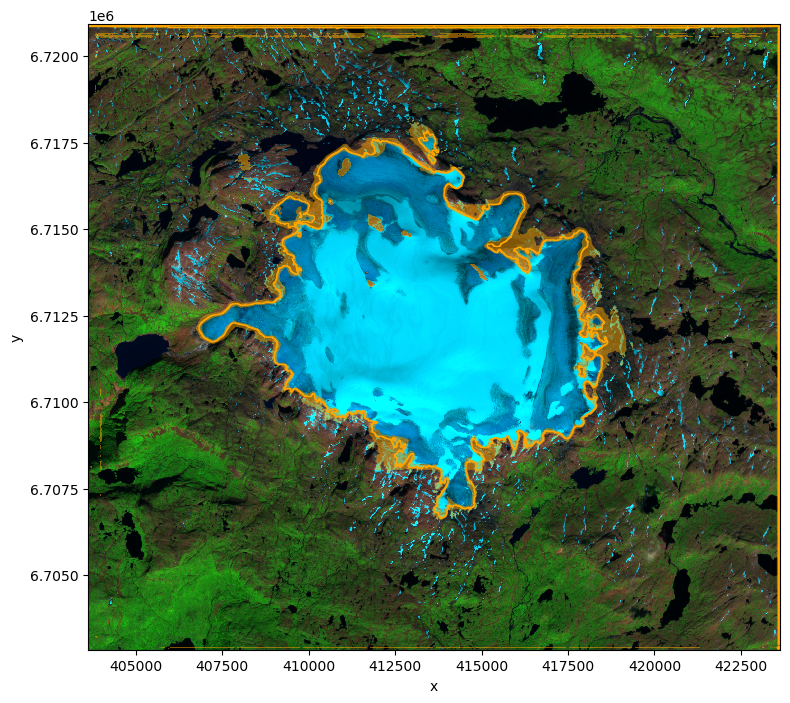

In [39]:
# finally, let's visualise the optical image with the classification results overlayed
vector_outlines = geopandas.read_file(vector_outlines_path)
vector_confidence_bands = geopandas.read_file(vector_confidence_bands_path)

_, ax = plt.subplots(figsize=(8, 8))

optical[[5, 3, 2]].plot.imshow(ax=ax, robust=True)
vector_confidence_bands.plot(ax=ax, edgecolor="None", facecolor="orange", alpha=0.5)
vector_outlines.plot(ax=ax, edgecolor="orange", facecolor="none")

ax.set_title("")

plt.tight_layout()
plt.show()